2024-06-24 08:56:25.677946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 08:56:25.678066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 08:56:25.817575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


n_neighbors: 8, min_dist: 0.05, silhouette_score: 0.7808475494384766
n_neighbors: 8, min_dist: 0.1, silhouette_score: 0.7602252960205078
n_neighbors: 8, min_dist: 0.15, silhouette_score: 0.7262158989906311
n_neighbors: 8, min_dist: 0.06, silhouette_score: 0.777775764465332
n_neighbors: 8, min_dist: 0.07, silhouette_score: 0.7545078992843628
n_neighbors: 8, min_dist: 0.08, silhouette_score: 0.7748181223869324
n_neighbors: 8, min_dist: 0.09, silhouette_score: 0.7473732233047485
n_neighbors: 9, min_dist: 0.05, silhouette_score: 0.7538259029388428
n_neighbors: 9, min_dist: 0.1, silhouette_score: 0.7331710457801819
n_neighbors: 9, min_dist: 0.15, silhouette_score: 0.7058565020561218
n_neighbors: 9, min_dist: 0.06, silhouette_score: 0.7769474387168884
n_neighbors: 9, min_dist: 0.07, silhouette_score: 0.7750526070594788
n_neighbors: 9, min_dist: 0.08, silhouette_score: 0.7347124218940735
n_neighbors: 9, min_dist: 0.09, silhouette_score: 0.738641083240509
n_neighbors: 10, min_dist: 0.05, silho

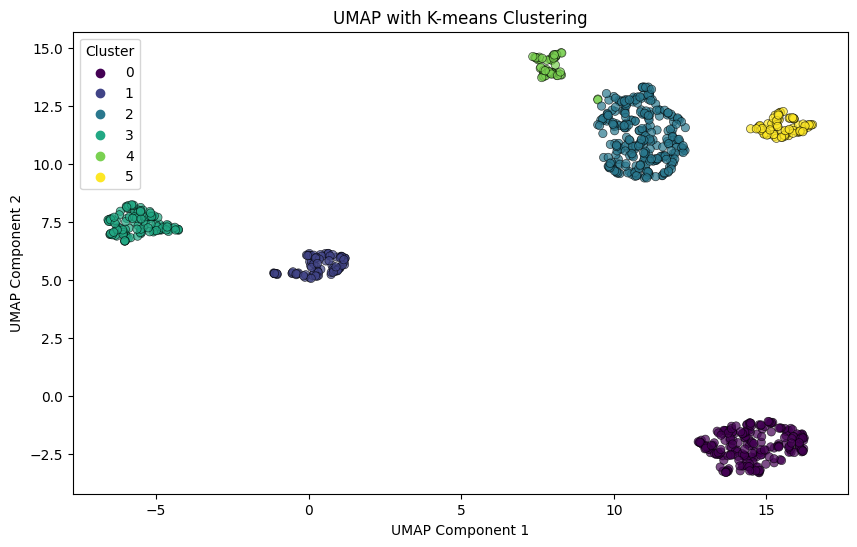

Submission file saved to submission.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 读取数据
train_url = "https://www.dropbox.com/scl/fi/trc40sel9ux3sy2v1wvti/train_clustering.csv?rlkey=w516y8ohuwb7upys3ozo13y7z&st=qeozuw97&dl=0&raw=1"
df_train = pd.read_csv(train_url, index_col=0)

# 选择特征
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

# 创建预处理Pipeline
preprocessor = ColumnTransformer([
    ('std_scal', StandardScaler(), numerical_cols),
], remainder='passthrough')

# 预处理数据
X_processed = preprocessor.fit_transform(df_train)

# 进一步细微搜索
best_silhouette_score = -1
best_params = None
best_labels = None

n_neighbors_range = range(8, 13)  # 在10附近搜索
min_dist_range = [0.05, 0.1, 0.15, 0.06, 0.07, 0.08, 0.09]  # 在0.1附近搜索

for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:
        umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2,)
        X_transformed = umap.fit_transform(X_processed)

        # K-means聚类
        kmeans = KMeans(n_clusters=6, n_init=20)
        labels = kmeans.fit_predict(X_transformed)

        # 计算轮廓系数
        silhouette_avg = silhouette_score(X_transformed, labels)
        print(f'n_neighbors: {n_neighbors}, min_dist: {min_dist}, silhouette_score: {silhouette_avg}')

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_params = (n_neighbors, min_dist)
            best_labels = labels

print(f'Best parameters found: n_neighbors={best_params[0]}, min_dist={best_params[1]}, silhouette_score={best_silhouette_score}')

# 使用最佳参数进行降维和聚类
umap = UMAP(n_neighbors=best_params[0], min_dist=best_params[1], n_components=2,)
X_transformed = umap.fit_transform(X_processed)
labels = best_labels

# 将聚类结果与原始数据结合
submission_df = df_train.copy()
submission_df['Cluster'] = labels

# 重置索引，将 MembershipID 恢复为普通列
submission_df.reset_index(inplace=True)

# 只保留 MembershipID 和 Cluster 两个列
submission_df = submission_df[['MembershipID', 'Cluster']]

# 输出到CSV文件
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

# 显示聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette='viridis', alpha=0.7, edgecolor='k')
plt.title('UMAP with K-means Clustering')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# 提示文件保存路径
print(f"Submission file saved to {submission_file_path}")
